# KTRLite Examples

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import orbit
from orbit.models.ktrlite import KTRLiteMAP
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)
print(matplotlib.__version__)

1.0.14dev
3.3.4


## Data

In [4]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

df[RESPONSE_COL] = np.log(df[RESPONSE_COL])

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2000-01-01 00:00:00
ends with 2008-12-31 00:00:00
shape: (3288, 2)


### Train / Test Split

In [6]:
test_size=365

train_df=df[:-test_size]
test_df=df[-test_size:]

## KTRLite

In [7]:
ktrlite = KTRLiteMAP(response_col=RESPONSE_COL,
                     date_col=DATE_COL,
                     # seasonality
                     seasonality=[7, 365.25],
                     seasonality_fs_order=[2, 5],
                     level_knot_scale=.1,
                     span_level=.05,
                     span_coefficients=.3,
                     estimator_type=StanEstimatorMAP,
                     n_bootstrap_draws=1e4)

In [8]:
ktrlite.fit(train_df)

Initial log joint probability = -259964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -6709.27      0.282432       11844.7      0.6157      0.6157       25   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39          4724     0.0329991       1943.69           1           1       47   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59        5019.5     0.0483992       674.189           1           1       68   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       5118.27     0.0108034       1105.58      0.7489      0.7489       89   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5154.13    0.00354182       894.972      0.6536      0.6536      114   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [9]:
predicted_df = ktrlite.predict(df=test_df, decompose=True)

predicted_df.head()

,date,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_365.25_5,seasonality_365.25,seasonality_365.25_95
0,2008-01-02,9.89906,10.01167,10.12097,9.90539,9.99511,10.08230,0.02477,0.02477,0.02477,-0.00821,-0.00821,-0.00821
1,2008-01-03,9.90306,10.01377,10.12525,9.90379,9.99511,10.08386,0.02746,0.02746,0.02746,-0.00880,-0.00880,-0.00880
2,2008-01-04,9.91234,10.02804,10.14026,9.90219,9.99511,10.08541,0.04215,0.04215,0.04215,-0.00922,-0.00922,-0.00922
3,2008-01-05,9.83881,9.95547,10.06656,9.90059,9.99511,10.08697,-0.03015,-0.03015,-0.03015,-0.00950,-0.00950,-0.00950
4,2008-01-06,9.78006,9.89765,10.01271,9.89899,9.99511,10.08853,-0.08784,-0.08784,-0.08784,-0.00962,-0.00962,-0.00962


In [10]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df['electricity'].values):.2%}"

'SMAPE: 0.46%'

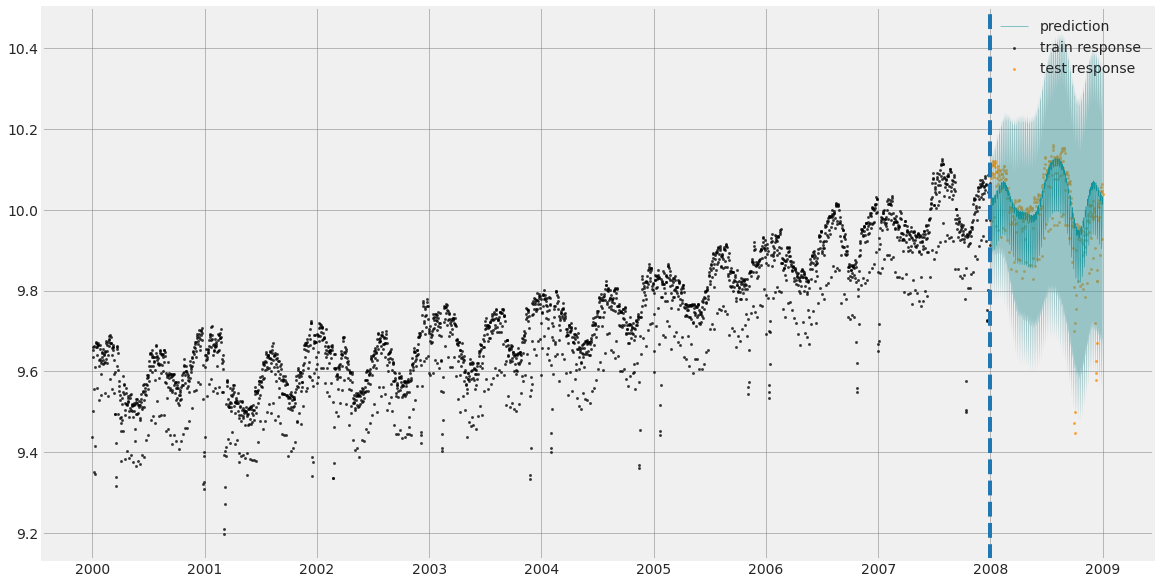

In [11]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df, 
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL, 
                        test_actual_df=test_df,
                        markersize=20, lw=.5)

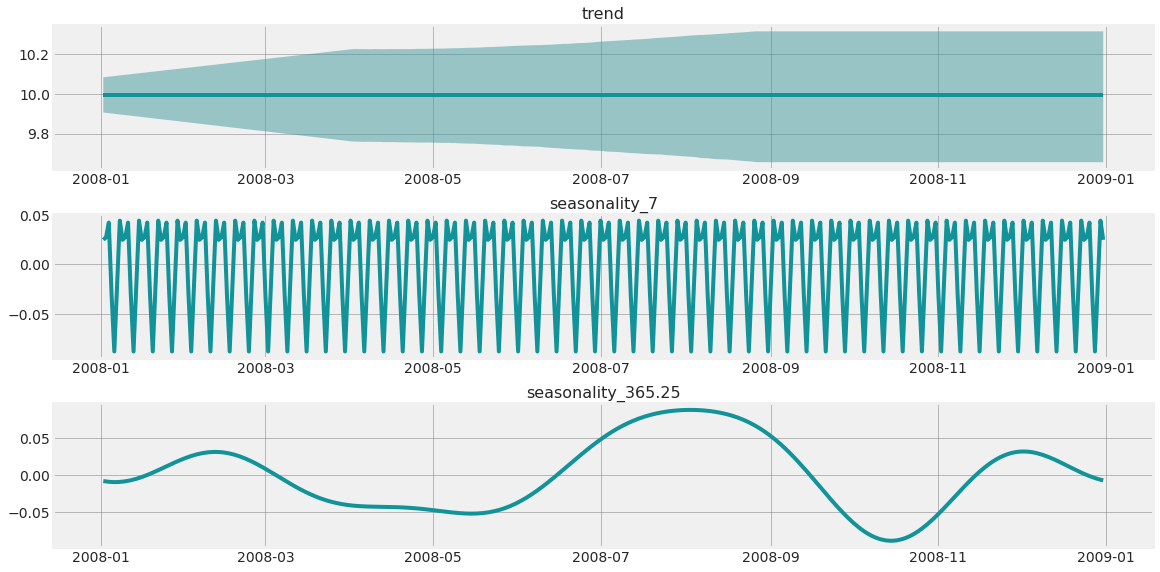

In [12]:
_ = plot_predicted_components(predicted_df=predicted_df,
                              date_col=DATE_COL, 
                              plot_components=['trend', 'seasonality_7', 'seasonality_365.25'])

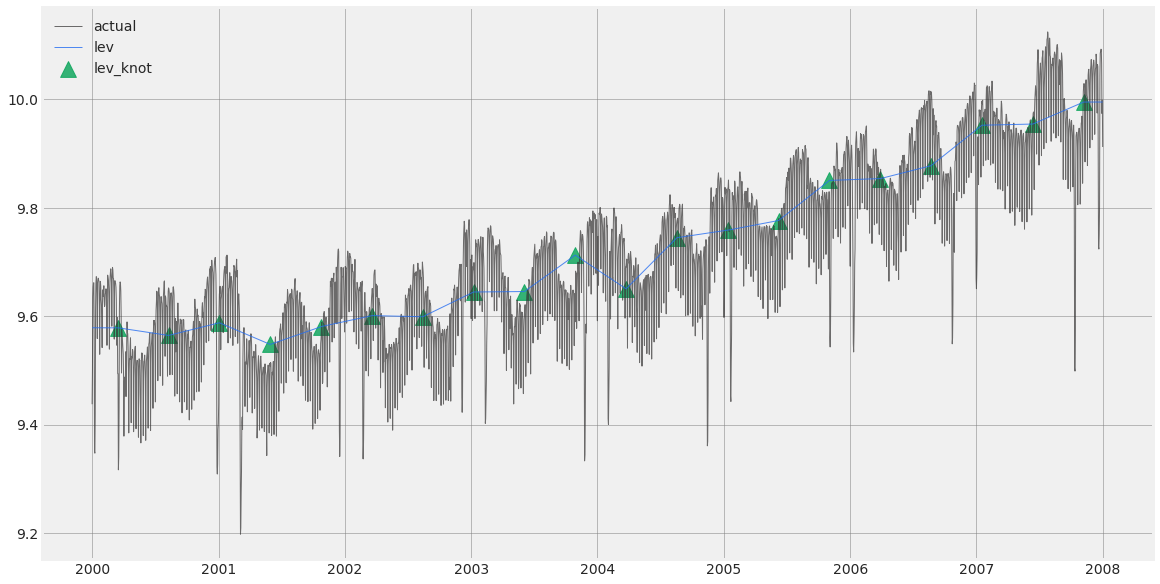

In [13]:
_ = ktrlite.plot_lev_knots()

In [14]:
lev_knots_df = ktrlite.get_level_knots()

lev_knots_df.head()

,date,lev_knot
0,2000-03-15,9.57867
1,2000-08-09,9.56450
2,2001-01-03,9.58786
3,2001-05-30,9.54788
4,2001-10-24,9.58077


In [15]:
lev_df = ktrlite.get_levels()

lev_df.head()

,date,lev
0,2000-01-01,9.57867
1,2000-01-02,9.57867
2,2000-01-03,9.57867
3,2000-01-04,9.57867
4,2000-01-05,9.57867


In [16]:
# stability check
ktrlite1 = KTRLiteMAP(response_col=RESPONSE_COL,
                      date_col=DATE_COL,
                      # seasonality
                      seasonality=[7, 365.25],
                      seasonality_fs_order=[2, 5],
                      span_coefficients=.3,
                      estimator_type=StanEstimatorMAP,
                      n_bootstrap_draws=-1,
                      seed=2020)


# stability check
ktrlite2 = KTRLiteMAP(response_col=RESPONSE_COL,
                      date_col=DATE_COL,
                      # seasonality
                      seasonality=[7, 365.25],
                      seasonality_fs_order=[2, 5],
                      span_coefficients=.3,
                      estimator_type=StanEstimatorMAP,
                      n_bootstrap_draws=-1,
                      seed=2021)

ktrlite1.fit(df)

ktrlite2.fit(df)

Initial log joint probability = -229922
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -384.232      0.329474       10532.3           1           1       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       5446.32     0.0227186       794.955           1           1       46   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       5476.06    0.00310394       118.698           1           1       66   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        5476.2   3.12204e-05       16.4099      0.2022      0.2022       90   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5476.21   9.18575e-06       22.0729           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha   